In [1]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.nn.functional import cross_entropy
from transformers import AutoModelForTokenClassification, AutoTokenizer
from transformers import DataCollatorForTokenClassification

import matplotlib.pyplot as plt
import pandas as pd
import pickle
import torch

In [2]:
with open('../../data/panx_ch.pkl', 'rb') as fh:
    panx_ch = pickle.load(fh)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def tokenize_and_align_labels(lazy_batch, tokenizer):
    tokenized_inputs = tokenizer(lazy_batch['tokens'], truncation=True, is_split_into_words=True)
    labels = []
    for ner_tag_idx, ner_tag in enumerate(lazy_batch['ner_tags']):
        label_ids = []
        previous_token_id = None
        for token_id in tokenized_inputs.word_ids(ner_tag_idx):
            if token_id is None or token_id == previous_token_id:
                label_ids.append(-100)
            else:
                label_ids.append(ner_tag[token_id])
            previous_token_id = token_id
        labels.append(label_ids)
    tokenized_inputs['labels'] = labels
    return tokenized_inputs


def encode_panx_dataset(panx_ch, tokenizer):
    return panx_ch.map(lambda x: tokenize_and_align_labels(x, tokenizer),
                       batched=True,
                       batch_size=1000,
                       remove_columns=['tokens', 'ner_tags', 'langs'])
    

def forward_pass_with_label(batch, data_collator, model):
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    batch = data_collator(features)
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)
    with torch.no_grad():
        output = model(input_ids, attention_mask)
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
    loss = cross_entropy(output.logits.view(-1, 7), labels.view(-1), reduction='none')
    loss = loss.view(len(input_ids), -1).cpu().numpy()
    return {'loss':loss, 'predicted_label':predicted_label}

In [4]:
model = AutoModelForTokenClassification.from_pretrained('../../model_checkpoints/ner_model_for_token_classification').to(device)
tokenizer = AutoTokenizer.from_pretrained('../../tokenizer_checkpoints/ner_tokenizer_for_token_classification')
data_collator = DataCollatorForTokenClassification(tokenizer)

In [5]:
# ner tags
tags = panx_ch['de']['train'].features['ner_tags'].feature  # a classLabel object
idx2tags = {idx: tag for idx, tag in enumerate(tags.names)}
tags2idx = {tag: idx for idx, tag in enumerate(tags.names)}

In [6]:
panx_de_encoded = encode_panx_dataset(panx_ch['de'], tokenizer)
validation_set = panx_de_encoded['validation']
validation_set = validation_set.map(lambda x: forward_pass_with_label(x, data_collator, model), batched=True, batch_size=32)
df_err = validation_set.to_pandas()
idx2tags[-100] = 'IGN'
df_err['input_tokens'] = df_err['input_ids'].apply(lambda x: tokenizer.convert_ids_to_tokens(x))
df_err['predicted_label'] = df_err['predicted_label'].apply(lambda x: [idx2tags[i] for i in x])
df_err['labels'] = df_err['labels'].apply(lambda x: [idx2tags[i] for i in x])
df_err['loss'] = df_err.apply(lambda x: x['loss'][:len(x['input_ids'])], axis=1)
df_err['predicted_label'] = df_err.apply(lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [7]:
df_tokens = df_err.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens['loss'] = df_tokens['loss'].astype(float).round(2)

In [8]:
(
    df_tokens.groupby('input_tokens')[['loss']]
    .agg(['count', 'mean', 'sum'])
    .droplevel(level=0, axis=1)
    .sort_values(by=['sum'], ascending=False)
    .reset_index()
    .round(2)
    .head(10)
    .T
)

,0,1,2,3,4,5,6,7,8,9
input_tokens,▁,▁der,▁in,▁von,▁'',▁/,▁und,▁(,▁),▁die
count,6066,1388,989,808,2898,163,1171,246,246,860
mean,0.04,0.1,0.13,0.14,0.03,0.48,0.06,0.3,0.28,0.06
sum,223.54,134.02,125.57,116.07,79.93,78.26,75.22,72.68,68.73,48.46


In [9]:
(
    df_tokens.groupby('labels')[['loss']]
    .agg(['count', 'mean', 'sum'])
    .droplevel(level=0, axis=1)
    .sort_values(by=['mean'], ascending=False)
    .reset_index()
    .round(2)
    .T
)

,0,1,2,3,4,5,6
labels,B-ORG,I-LOC,I-ORG,B-LOC,B-PER,I-PER,O
count,2683,1462,3820,3172,2893,4139,43648
mean,0.62,0.59,0.47,0.34,0.28,0.2,0.03
sum,1672.94,867.62,1798.1,1069.78,798.84,818.53,1296.67


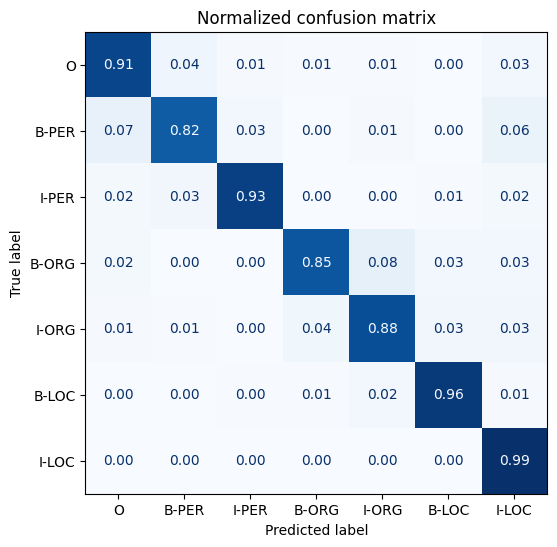

In [10]:
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
    plt.title('Normalized confusion matrix')
    plt.show()
    

plot_confusion_matrix(df_tokens['labels'], df_tokens['predicted_label'], tags.names)

In [13]:
def get_samples(df):
    for _, row in df.iterrows():
        labels, preds, tokens, losses = [], [], [], []
        for i, mask in enumerate(row["attention_mask"]):
            if i not in {0, len(row["attention_mask"])}:
                labels.append(row["labels"][i])
                preds.append(row["predicted_label"][i])
                tokens.append(row["input_tokens"][i])
                losses.append(f"{row['loss'][i]:.2f}")
        df_tmp = pd.DataFrame({"tokens": tokens, "labels": labels,
                               "preds": preds, "losses": losses}).T
        yield df_tmp
        

df_err["total_loss"] = df_err["loss"].apply(sum)
df_tmp = df_err.sort_values(by="total_loss", ascending=False).head(3)

for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
tokens,▁',▁'',▁Τ,Κ,▁'',▁',▁',▁'',▁T,▁'',▁',ri,▁'',▁',k,▁'',▁',ala,</s>
labels,O,O,O,IGN,O,O,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,IGN
preds,O,O,B-ORG,I-ORG,O,O,O,O,B-ORG,O,O,B-ORG,O,O,B-ORG,O,O,O,O
losses,0.00,0.00,4.80,0.00,0.00,0.00,9.77,10.47,7.55,9.05,9.44,0.00,8.30,9.66,0.00,9.35,9.49,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
tokens,▁'',8,.,▁Juli,▁'',▁:,▁Protest,camp,▁auf,▁dem,▁Gelände,▁der,▁Republika,n,ischen,▁Gar,de,</s>
labels,B-ORG,IGN,IGN,I-ORG,I-ORG,I-ORG,I-ORG,IGN,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,IGN,IGN,I-ORG,IGN,IGN
preds,O,O,O,O,O,O,O,O,O,O,O,O,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,O
losses,8.16,0.00,0.00,4.95,8.79,8.93,7.38,0.00,8.36,8.66,7.78,5.94,7.24,0.00,0.00,0.01,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
tokens,▁United,▁Nations,▁Multi,dimensional,▁Integra,ted,▁Stabil,ization,▁Mission,▁in,▁the,▁Central,▁African,▁Republic,</s>
labels,B-PER,I-PER,I-PER,IGN,I-PER,IGN,I-PER,IGN,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,6.48,5.70,5.78,0.00,5.86,0.00,5.86,0.00,5.46,5.85,5.88,5.58,5.24,5.13,0.00
